In [ ]:
# K-means

## 0. 

In [160]:
import math, numpy as np
from numpy import random
from scipy.stats import pearsonr

def kmeans(X, k, tp='2LP') :
    THRESHOLD = 1E-5
    newMiu = [random.uniform(min(dim), max(dim), k) for dim in X]; miu = np.zeros([len(X)-1, k])
    groups = [0]*len(X[0])
    while max([dist([dim[i] for dim in miu],[dim[i] for dim in newMiu], tp) for i in range(k)]) > THRESHOLD :
        minDists = [float('inf')]*len(X[0])
        for i in range(len(X[0])) :
            for j in range(k) :
                d = dist([dim[i] for dim in X], [dim[j] for dim in newMiu], tp)
                if d < minDists[i] :
                    minDists[i] = d
                    groups[i] = j
        miu = newMiu
        newMiu = [[np.mean([dim[m] for m in range(len(X[0])) if groups[m] == j]) for j in range(k)] for dim in X]
    return newMiu, groups

def dist(X, Y, tp='2LP') :
    if tp == '1LP' :
        return sum([abs(i-j) for i,j in zip(X,Y)])
    elif tp == '2LP' :
        return math.sqrt(sum([(i-j)**2 for i,j in zip(X,Y)]))
    elif tp == 'InfLP' :
        return max([abs(i-j) for i,j in zip(X,Y)])
    else :
        return -1

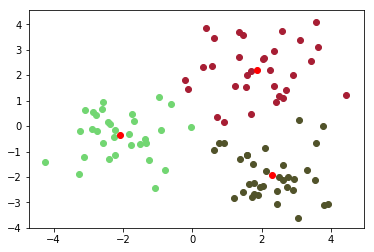

In [161]:
%matplotlib inline
from matplotlib import pyplot as plt
from numpy import random

# Uniformly generate random points
SIZE = 100
X = list(random.randn(SIZE//3) + 2) + list(random.randn(SIZE//3) + 2) + list(random.randn(SIZE//3) - 2)
Y = list(random.randn(SIZE//3) + 2) + list(random.randn(SIZE//3) - 2) + list(random.randn(SIZE//3))

# k-means
GROUPS = 3
miu, groups = kmeans([X, Y], GROUPS, '1LP')

# Scatter
plt.figure()
for j in range(GROUPS) :
    plt.scatter([p for i,p in enumerate(X) if groups[i] == j], [p for i,p in enumerate(Y) if groups[i] == j], \
                c=random.rand(3))
_ = plt.scatter(miu[0], miu[1], c='red')

In [252]:
# Using UCI database iris

# read data
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
FEATURES = 4; GROUPS = 3
fi = open('../databases/iris/iris.data')
X = []; tags = []
for i in range(FEATURES) :
    X.append([])
for line in fi :
    tmp = line.split(',')
    for i in range(FEATURES) :
        X[i].append(float(tmp[i]))
    tags.append(labels.index(tmp[FEATURES].strip()))

# kmeans
_, groups = kmeans(X, GROUPS, '2LP')

# scoring
score = 0
for i in range(GROUPS) :
    tmp = sum([groups[j] == (tags[j]+i)%GROUPS for j in range(len(tags))])
    if tmp > score :
        score = tmp
print('Accuracy of iris categorization by k-means:', score/len(tags))

Accuracy of iris categorization by k-means: 0.8933333333333333
